###Installtion and Setup

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-h2vhwo7w
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-h2vhwo7w
     |████████████████████████████████| 596 kB 5.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65172 sha256=700c83603f7f3f091df72e37df631584e401440f315798ea535656e17bc1cfb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-gib9oh39/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.11.0+cu113'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MIT/3.\ Spring\ 2022/6.869/6.869\ Project/v-coco/
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Mounted at /content/drive
/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco
fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/drive/MyDrive/MIT/3.%20Spring%202022/6.869/6.869%20Project/v-coco/detectron2_repo
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 147 kB 10.7 MB/s 
     |████████████████████████████████| 130 kB 71.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 749 kB 63.3 MB/s 
     |████████████████████████████████| 843 kB 64.9 MB/s 
     |████████████████████████████████| 112 kB 78.9 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=5b85937a9fac66a8d97d7668bdb2b647159222f001e85e42d1739e91783933e5
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully buil

###Imports

In [ ]:
# Some basic setup:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MIT/3.\ Spring\ 2022/6.869/6.869\ Project/v-coco/


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from PIL import Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import ColorMode

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco


In [ ]:
data_dir = "/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco"
test_data_dir = "/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/GroceryData"
model_dir = "/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco/outputs"

In [ ]:
from detectron2.data.datasets import register_coco_instances

global already_run 
already_run = False
def loadData():
  global already_run 
  if already_run: return

  options = {
      "action_obj": {"anno_path": "./data/instances_vcoco_agent_object_train.json", "image_path": "./coco/train2014"},
      "action_only": {"anno_path": "./data/instances_vcoco_actions_train.json", "image_path": "./coco/train2014"},
      "cutouts": {"anno_path": "./data/instances_vcoco_object_cutours_train.json", "image_path": "./coco/train2014_cutouts"},
  }

  for key in options.keys():
    option = options[key]
    register_coco_instances(key, {}, option["anno_path"], option["image_path"])
  already_run = True

loadData()

def getMetaData(key):
  train_metadata = MetadataCatalog.get(key)
  train_dicts = DatasetCatalog.get(key)
  return (train_metadata, train_dicts)

### Utilities

In [ ]:
def run_inference(predictor, im_path):
  im = cv2.imread(im_path)
  outputs = predictor(im)
  x = outputs["instances"].to("cpu")
  return x


def visualize(outputs, key="empty"):
  if key == "empty": raise "You need a key"
  print(MetadataCatalog.get(key))
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(key), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


def cutout_box(im, boxes, display=False, baseImage=False):
  """Removes all pixels but objects
  """
  background = Image.new('RGB', (im.shape[1], im.shape[0]), (0, 0, 0))
  new_fg_image = Image.new('RGB', background.size)
  if type(baseImage) != bool: new_fg_image = Image.fromarray(baseImage)
  for box in boxes:
    segmentation = box
    x_min = int(segmentation[0])
    y_min = int(segmentation[1])
    x_max = int(x_min + segmentation[2])
    y_max = int(y_min + segmentation[3])
    # print(x_min, x_max, y_min, y_max)

    cropped = Image.fromarray(im[y_min:y_max, x_min:x_max, :], mode='RGB')
    paste_position = (x_min, y_min)
    new_fg_image.paste(cropped, paste_position)

  if display: cv2_imshow(np.array(new_fg_image))

  return new_fg_image

def crop_object_from_pred_boxes(image_path, box):
  """Crops an object out of an image
  """
  image = Image.open(image_path)
  x_top_left = box[0]
  y_top_left = box[1]
  x_bottom_right = box[2]
  y_bottom_right = box[3]
  x_center = (x_top_left + x_bottom_right) / 2
  y_center = (y_top_left + y_bottom_right) / 2

  crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))
  return crop_img

def get_people(outputs, person_id=0):
  classes = outputs.pred_classes.detach().cpu().numpy()
  people_ids = [idx for idx, tag in enumerate(classes) if idx == person_id]
  people = []
  for p_idx in people_ids:
    person = {
      "box": outputs.pred_boxes[p_idx].tensor.cpu().numpy()[0],
      "score": outputs.scores[p_idx],
      "class": outputs.pred_classes[p_idx],
    }
    people.append(person)

  return people

def get_person_obj_pairs(outputs, person_id=0):
  classes = outputs.pred_classes.detach().cpu().numpy()
  people_ids = [idx for idx, tag in enumerate(classes) if idx == person_id]
  obj_ids = [idx for idx, tag in enumerate(classes) if idx != person_id]

  pairs = []
  for p_idx in people_ids:
    person = {
        "box": outputs.pred_boxes[p_idx].tensor.cpu().numpy()[0],
        "score": outputs.scores[p_idx],
        "class": outputs.pred_classes[p_idx],
    }
    for o_idx in obj_ids:
      obj = {
          "box": outputs.pred_boxes[o_idx].tensor.cpu().numpy()[0], 
          "score": outputs.scores[o_idx], 
          "class": outputs.pred_classes[o_idx],
      }
      pair = (person, obj)
      pairs.append(pair)

  return pairs

def get_test_images():
  # 'image06.png',
  paths = image_list = ['image02.jpeg', 'image01.jpeg', 'image03.jpeg', 'image04.jpeg', 'image05.jpeg',  'image07.jpeg', 'image08.jpeg', 'image09.png', 'image10.jpeg', 'image11.png', 'image12.jpeg', 'image13.jpeg', 'image14.jpeg', 'image36.jpeg', 'image37.jpeg', 'image38.jpeg', 'image39.jpeg', 'image40.jpeg', 'image41.jpeg', 'image42.jpeg', 'image43.jpeg', 'image44.jpeg', 'image45.jpeg', 'image46.jpeg', 'image47.jpeg', 'image48.jpeg', 'image49.jpeg', 'image50.jpeg']
  paths = [ "../GroceryImages/"+img for img in paths]
  return paths

### Model Loading

In [140]:
#Get the default config and set for pre-made RCNN Object Detector
cfg_obj = get_cfg()
cfg_obj.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_obj.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # set threshold for this model
cfg_obj.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
obj_detector = DefaultPredictor(cfg_obj)

#Classifies actions of people
cfg_action = get_cfg()
cfg_action.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg_action.MODEL.WEIGHTS = os.path.join("outputs/action_detector", "model_final.pth")
cfg_action.DATALOADER.NUM_WORKERS = 2
cfg_action.SOLVER.IMS_PER_BATCH = 2
cfg_action.SOLVER.BASE_LR = 0.002
cfg_action.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg_action.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg_action.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
cfg_action.DATASETS.TRAIN = ("action_only",)
action0_trainer = DefaultTrainer(cfg_action)
# action0_trainer.train()
action0_detector = DefaultPredictor(cfg_action)

#Finds action agents and action objects
cfg_action_obj = get_cfg()
cfg_action_obj.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_action_obj.MODEL.WEIGHTS = os.path.join("outputs/action_object_detector", "model_final.pth")
cfg_action_obj.DATALOADER.NUM_WORKERS = 2
cfg_action_obj.SOLVER.IMS_PER_BATCH = 2
cfg_action_obj.SOLVER.BASE_LR = 0.002
cfg_action_obj.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg_action_obj.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg_action_obj.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
cfg_action_obj.DATASETS.TRAIN = ("action_obj",)
action1_trainer = DefaultTrainer(cfg_action_obj)
action1_trainer.train()
action1_detector = DefaultPredictor(cfg_action_obj)


#Finds action agents
cfg_action_agent = get_cfg()
cfg_action_agent.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg_action_agent.MODEL.WEIGHTS = os.path.join("outputs/action_object_localizer", "model_final.pth")
cfg_action_agent.DATALOADER.NUM_WORKERS = 2
cfg_action_agent.SOLVER.IMS_PER_BATCH = 2
cfg_action_agent.SOLVER.BASE_LR = 0.002
cfg_action_agent.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg_action_agent.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg_action_agent.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
cfg_action_agent.DATASETS.TRAIN = ("action_obj",)
action_agent_trainer = DefaultTrainer(cfg_action_agent)
action_agent_trainer.train()
action2_detector = DefaultPredictor(cfg_action_agent)


#Finds object targets for given person/action pairs
cfg_action_obj_loc2 = get_cfg()
cfg_action_obj_loc2.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg_action_obj_loc2.MODEL.WEIGHTS = os.path.join("outputs/action_object_localizer2", "model_final.pth")
cfg_action_obj_loc2.DATALOADER.NUM_WORKERS = 2
cfg_action_obj_loc2.SOLVER.IMS_PER_BATCH = 2
cfg_action_obj_loc2.SOLVER.BASE_LR = 0.002
cfg_action_obj_loc2.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg_action_obj_loc2.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg_action_obj_loc2.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
cfg_action_obj_loc2.DATASETS.TRAIN = ("cutouts",)
target_trainer = DefaultTrainer(cfg_action_obj_loc2)
target_trainer.train()
target_detector = DefaultPredictor(cfg_action_obj_loc2)

[05/09 03:06:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:03, 33.2MB/s]                            


[05/09 03:06:06 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[05/09 03:06:06 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[05/09 03:06:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

FileNotFoundError: ignored

### Execution Pipeline

(525, 491, 3)
{'instances': Instances(num_instances=0, image_height=525, image_width=491, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 525, 491), dtype=torch.bool)])}
Metadata(evaluator_type='coco', image_root='./coco/train2014', json_file='./data/instances_vcoco_actions_train.json', name='action_only')


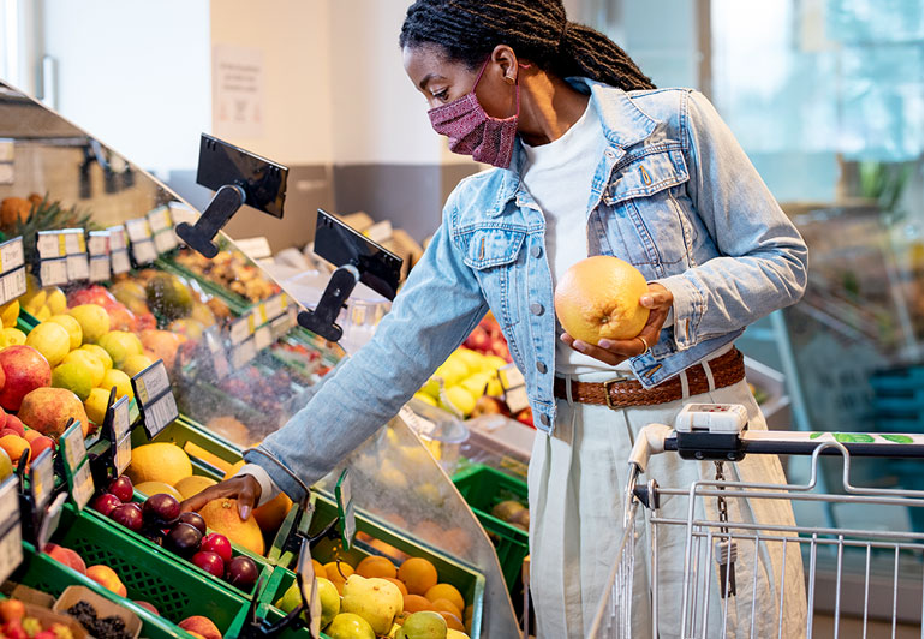

NameError: ignored

In [ ]:
image_paths = get_test_images()

for path in image_paths:
  #load image for inference
  im = cv2.imread(path)

  #get all objects found in image
  obj_outputs = obj_detector(im)
  # visualize(obj_outputs, cfg_obj.DATASETS.TRAIN[0])

  #Get all person and personobject pairs
  pers = get_people(obj_outputs["instances"])
  per_obj_pairs = get_person_obj_pairs(obj_outputs["instances"])

  #classify actions of people
  actions = []
  for person in pers:
    box = person["box"]
    per_crop = crop_object_from_pred_boxes(path, box)
    per_crop = np.array(per_crop) 
    print(per_crop.shape)
    act_ouputs = action0_detector(per_crop)
    print(act_ouputs)
    visualize(act_ouputs, "action_only")
    e
    actions.append(act_ouputs)
  
  #classify all targets of people's actions
  for pair in per_obj_pairs:
    boxes = (pair[0]["box"], pair[1]["box"])
    cutout_img = cutout_box(im, boxes)
    target_outputs = target_detector(np.array(cutout_img))
    print(target_outputs)
    # visualize(target_outputs, "action_only")


# action_obj
# action_only
# cutouts